# On-the-fly noise simulations in CAR pixelization

We'll now switch to working with maps that are in the Plate-Caree (CAR) projection stored in 2d grids of rectangular pixels. The 2d rectangular aspect allows us to work with maps as numpy arrays, which is especially efficient at storing partial skies. The CAR projection aspect means that spherical harmonic transforms are possible.

We use the `pixell` library to work with these maps. Please watch the tutorial on using `pixell` here: https://www.simonsfoundation.org/event/so-theory-tutorial/


In [87]:
# We load the mapsims library as before
import mapsims
# pixell.enmap is for general map manipulation
# pixell.curvedsky is for SHT-related operations
# pixell.utils is for general utilities; we use it for units
# pixell.enplot lets us make high-resolution visualizations of the map using the Python Image Library
from pixell import enmap, curvedsky as cs, utils, enplot
import numpy as np
# We'll use healpy to do an alm -> cl operation
import healpy as hp
import matplotlib.pyplot as plt

Previous notebooks have demonstrated on-the-fly simulations using a higher-level interface that involves configuration files. We'll step into the lowest levels to show you the guts of the code. Accessing it this way gives you maximum flexibility in adapting the underlying models.

The core class for noise simulations is `SONoiseSimulator`. It wraps around the SO noise forecast code, which provides noise power spectra (including atmospheric 1/f and white noise) assuming uniform coverage in a specified sky fraction. In addition, it knows about the "hit-count" information for various SO detector tubes (produced by the scan strategy / time domain working groups) through interfaces with remote locations for maps that encode these. It caches these hitmaps locally on disk on first use, and in memory during repeated calls for realizations of the noise.

The hit-counts are used to modulate the SO noise forecast power spectra to produce Gaussian realization maps that are inhomogenous.

Let's examine the class to see how to initialize it:

In [108]:
mapsims.noise.SONoiseSimulator?

We see that we need to specify either HEALPIX nside or the shape,wcs pair for a CAR map. Let's not go full-resolution for this demo, instead imagining that our simulated maps will have 2 arcmin wide pixels (instead of the 0.5 arcmin we need at 150 GHz for full Nyquist sampling). We ask for our output maps to be projected to a full-sky template with that resolution.

In [109]:
shape,wcs = enmap.fullsky_geometry(res=2.0 * utils.arcmin)
nsim = mapsims.noise.SONoiseSimulator(shape=shape,wcs=wcs)

We've instantiated the noise simulator object. The main member function we need is `simulate`, we generates a Gaussian random field with the default inhomogenity and noise power spectra. Let's examine its signature:

In [110]:
nsim.simulate?

We need to specify the name of an SO tube. Let's go with the LAT's LT3 tube. This is a dichroic array containing 150 GHz and 90 GHz channels. We specify a mask value in the unobserved region of zero instead of the default numpy.nan:

In [111]:
tube = 'LT3'
omap = nsim.simulate(tube,mask_value=0)

/home/msyriac/.local/lib/python3.8/site-packages/mapsims/utils.py:76: UserWarning: Retrieve data for LT3_MFF1_01_of_20.nominal_telescope_all_time_all_hmap_CAR_2.00_arcmin.fits.gz (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")
/home/msyriac/.local/lib/python3.8/site-packages/mapsims/utils.py:76: UserWarning: Retrieve data for LT3_MFF2_01_of_20.nominal_telescope_all_time_all_hmap_CAR_2.00_arcmin.fits.gz (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")


Let's examine the shape and wcs of the returned map:

In [92]:
print(omap.shape)
print(omap.wcs)

(2, 1, 3, 5401, 10800)
car:{cdelt:[-0.03333,0.03333],crval:[0.01667,0],crpix:[5400,2701]}


Why is the map 5-dimensional? The dimension convention in this noise generator is:

```
(narray,nsplit,ncomp,Ny,Nx)
```

`Ny` and `Nx` are the usual vertical (declination) and horizontal (RA) pixel lengths of the underlying 2d maps. `ncomp=3` since there are three maps in each array for each of the I,Q,U Stokes components. This code allows us to generate indepndent splits of the map, where each split has `nsplits` larger noise power than specified, with the default being no splitting (`nsplits=1`). Finally, the leading dimensions of the map always have length `narray=2` corresponding to the two correlated dichroic arrays within a tube, in this case the 90 GHz and 150 GHz channels of the LAT's LT3 tube. 

Let's focus on the intensity I of the 90 GHz map, and plot it:

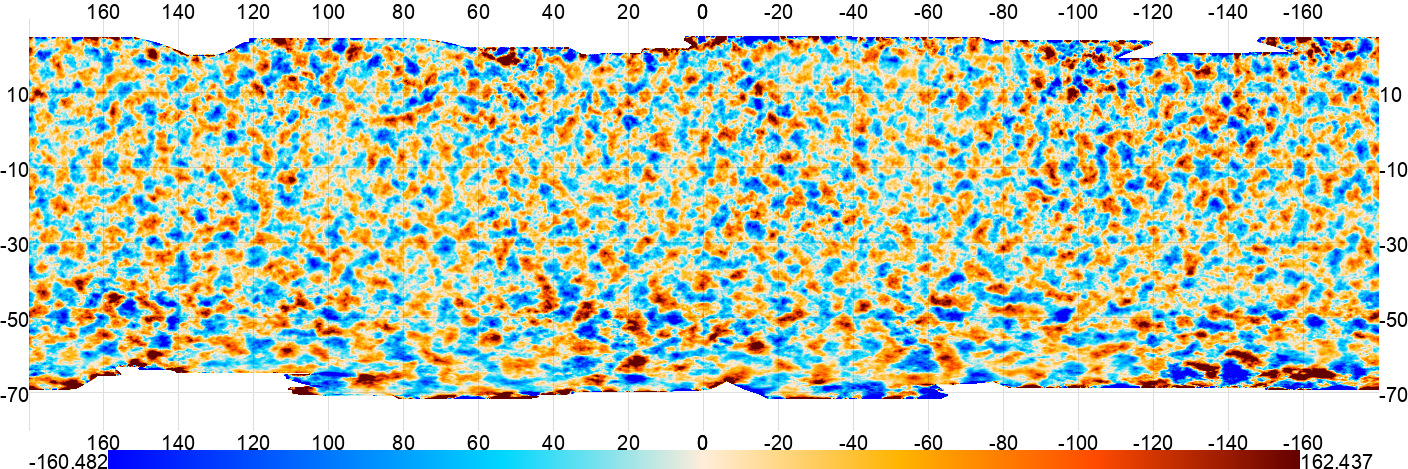

In [129]:
tmap1 = omap[0,0,0]
enplot.show(enplot.plot(tmap1,downgrade=8,grid=True,ticks=20,mask=0,colorbar=True))

That looks like noise. Noice. We notice that it is very much not white -- we see noise mostly on large scales from the atmosphere at this zoom level. It's also very inhomogeneous, with the noise blowing up near the edges. We don't see any stripiness -- because the SO map-based noise model is too simplistic to capture that! We also find that compared to previous versions of the SO map-based noise sims, we're not just seeing noise modes at the largest scales dominate, since the noise power has been rolled off on large scales to simulate what happens in a realistic map-maker run that doesn't converge fully on the largest scales (and the atmospheric noise doesn't keep arbitrarily increasing anyway).


We also see that we waste quite a lot of space in memory storing all those zero pixels. Let's utilize the cut-sky benefits of working with CAR pixels and define a smaller template limited to the -80 to 30 degree declination region, and re-initialize our noise simulator with that.

In [114]:
shape,wcs = enmap.band_geometry(dec_cut=np.asarray((-80,30))*utils.degree,res=2.0 * utils.arcmin)
nsim = mapsims.noise.SONoiseSimulator(shape=shape,wcs=wcs)

In [115]:
omap = nsim.simulate(tube,mask_value=0)

/home/msyriac/.local/lib/python3.8/site-packages/mapsims/utils.py:76: UserWarning: Retrieve data for LT3_MFF1_01_of_20.nominal_telescope_all_time_all_hmap_CAR_2.00_arcmin.fits.gz (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")
/home/msyriac/.local/lib/python3.8/site-packages/mapsims/utils.py:76: UserWarning: Retrieve data for LT3_MFF2_01_of_20.nominal_telescope_all_time_all_hmap_CAR_2.00_arcmin.fits.gz (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")


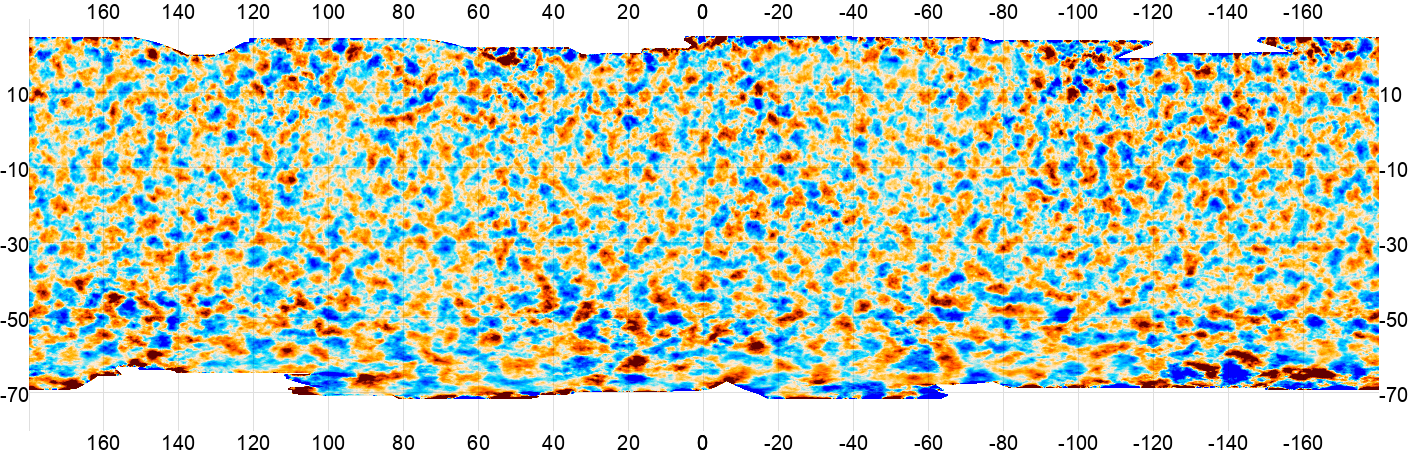

In [131]:
tmap1 = omap[0,0,0]
plot = lambda x,**kwargs: enplot.show(enplot.plot(x,downgrade=8,grid=True,ticks=20,mask=0,**kwargs))
plot(tmap1)

Ok, that looks a bit tighter -- we're more memory efficient and our SHTs (and iSHT based sim generation) will be faster.

A very useful auxiliary product to have is the inverse noise variance in each pixel (units 1/muK^2). Let's get that.

In [117]:
ivar = nsim.get_inverse_variance(tube)
print(ivar.shape)

/home/msyriac/.local/lib/python3.8/site-packages/mapsims/utils.py:76: UserWarning: Retrieve data for LT3_MFF1_01_of_20.nominal_telescope_all_time_all_hmap_CAR_2.00_arcmin.fits.gz (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")
/home/msyriac/.local/lib/python3.8/site-packages/mapsims/utils.py:76: UserWarning: Retrieve data for LT3_MFF2_01_of_20.nominal_telescope_all_time_all_hmap_CAR_2.00_arcmin.fits.gz (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")


(2, 3300, 10800)


In our noise model, all the splits and all the I,Q,U components have the same position dependence of the noise. You just have to keep in mind that each split just has `nsplits` times the noise power (or `1/nsplits` the inverse noise variance) and that the Q,U components have 2x times the noise power (or 1/2 times the inverse noise variance) of the intensity components.

The inverse noise variance provided by the function above is for the `nsplits=1` intensity component. It has two components, one for each of the two correlated arrays in the dichroic tube. We pick the first one, since that's the one corresponding to the map we just simulated:

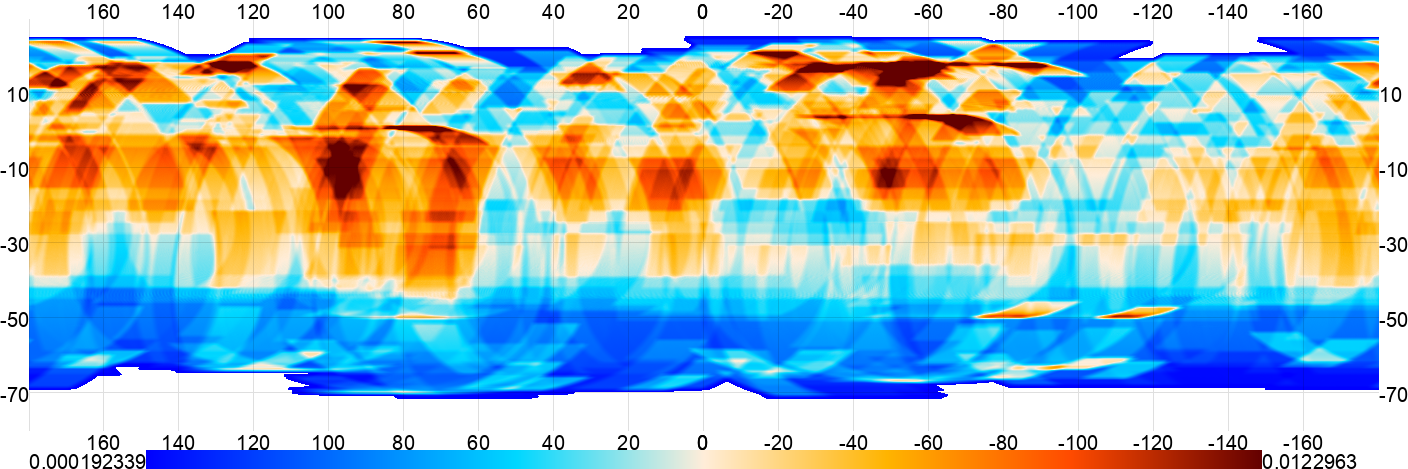

In [128]:
ivar1 = ivar[0]
plot(ivar1,colorbar=True)

And now we see the underlying inhomogenity much better. The inverse noise variance is directly proportional the hit-count maps taken as the input for the noise model. You can clearly see the scan strategy here.

We can use the inverse noise variance map together with the simulated map to verify that our simulations match the input spectra.

The basic idea is that for a simulated map $M$ and inverse noise variance $N^{-1}$, the power spectrum of 

$$
M \sqrt{N^{-1}}
$$

should be identical to the standardized SO noise power spectrum, i.e. the original noise power spectrum but with the white noise power divided out, such that the power spectrum asymptotes to 1 on small scales. This is in fact the *definition* of the noise model we use. You can think of it as standardizing or normalizing the small-scale / high-ell behaviour by dividing the per-pixel standard deviation, i.e. if our noise model were perfectly homogenous with no 1/f atmospheric component, all I would have been saying was that if you divided each pixel by its standard deviation, you would get a white noise power spectrum with value 1. 


So we'll just do that. Multiply our map by the map of the inverse noise variance, take its power spectrum and compare to the input model. We do have to take into account that the inverse noise variance is provided *per pixel* (in units of uK-steradian), so we have to divide out the pixel area. Recall that the CAR pixelization is not equal area, so we need a *map* of the pixel areas. We could get this from `enmap.pixsizemap(shape,wcs)`, but instead we'll just used the pre-calculated one stored in the noise sim generator:

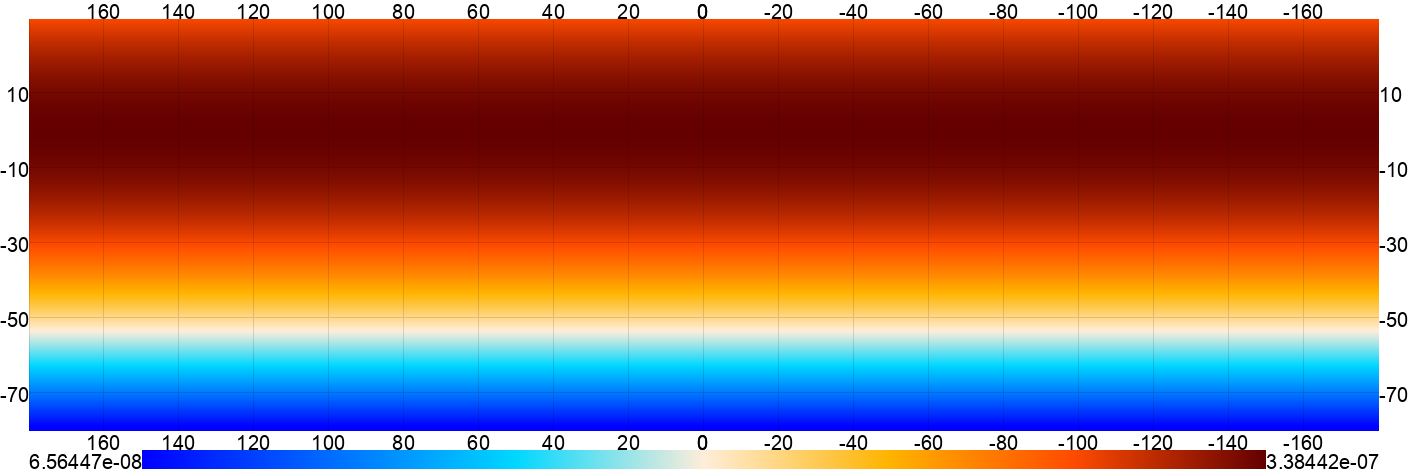

In [127]:
pmap = nsim.pixarea_map
plot(pmap,colorbar=True)

Let's plot the standardized map (which should look homogeneous):

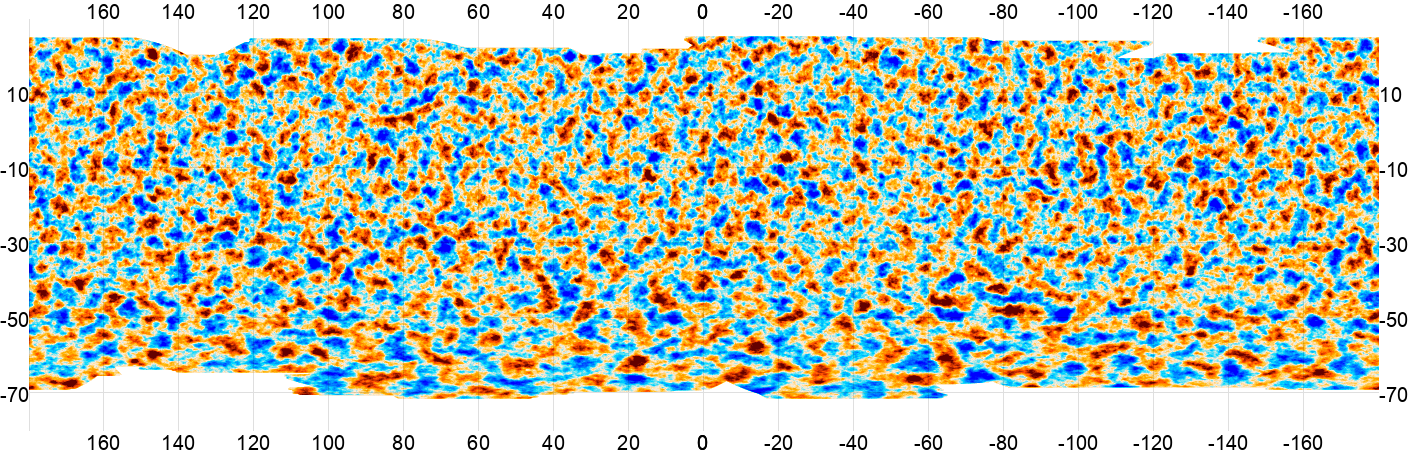

In [133]:
plot(np.sqrt(ivar1/pmap)*tmap1)

Now we calculate the power spectrum of the standardized map, making sure to correct approximately for the incomplete-sky coverage:

In [125]:
alm = cs.map2alm(np.sqrt(ivar1/pmap)*tmap1,lmax=5000)
mask = tmap1*0 + 1
w2 = np.sum((mask**2)*pmap) /np.pi / 4.
print(w2)
cls = hp.alm2cl(alm) / w2

0.742303121975512


What do 

In [134]:
nsim.get_noise_properties?
ells,ps_T,ps_P,fsky,wnoise,hitmaps = nsim.get_noise_properties(tube)
print(ps_T.shape)

/home/msyriac/.local/lib/python3.8/site-packages/mapsims/utils.py:76: UserWarning: Retrieve data for LT3_MFF1_01_of_20.nominal_telescope_all_time_all_hmap_CAR_2.00_arcmin.fits.gz (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")
/home/msyriac/.local/lib/python3.8/site-packages/mapsims/utils.py:76: UserWarning: Retrieve data for LT3_MFF2_01_of_20.nominal_telescope_all_time_all_hmap_CAR_2.00_arcmin.fits.gz (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")


(3, 5000)


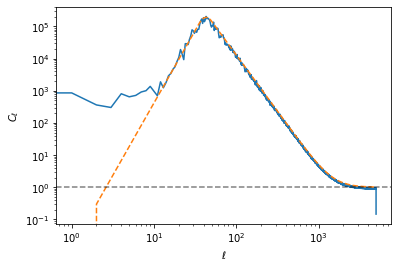

In [102]:
ls = np.arange(cls.size)
plt.plot(ls,cls)
plt.plot(ells,ps_T[0]/wnoise[0],ls='--')
plt.axhline(y=1,color='k',ls='--',alpha=0.5)
plt.xlabel('$\\ell$')
plt.ylabel('$C_{\\ell}$')
plt.yscale('log')
plt.xscale('log')
plt.show()

In [103]:
rms = np.sqrt(wnoise[0]) * 180.*60/np.pi
print(rms)

12.19384084268382


## Simplifying the noise model (e.g. for controlled tests)

We can turn off the 1/f (atmosphere):

/home/msyriac/.local/lib/python3.8/site-packages/mapsims/utils.py:76: UserWarning: Retrieve data for LT3_MFF1_01_of_20.nominal_telescope_all_time_all_hmap_CAR_2.00_arcmin.fits.gz (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")
/home/msyriac/.local/lib/python3.8/site-packages/mapsims/utils.py:76: UserWarning: Retrieve data for LT3_MFF2_01_of_20.nominal_telescope_all_time_all_hmap_CAR_2.00_arcmin.fits.gz (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")


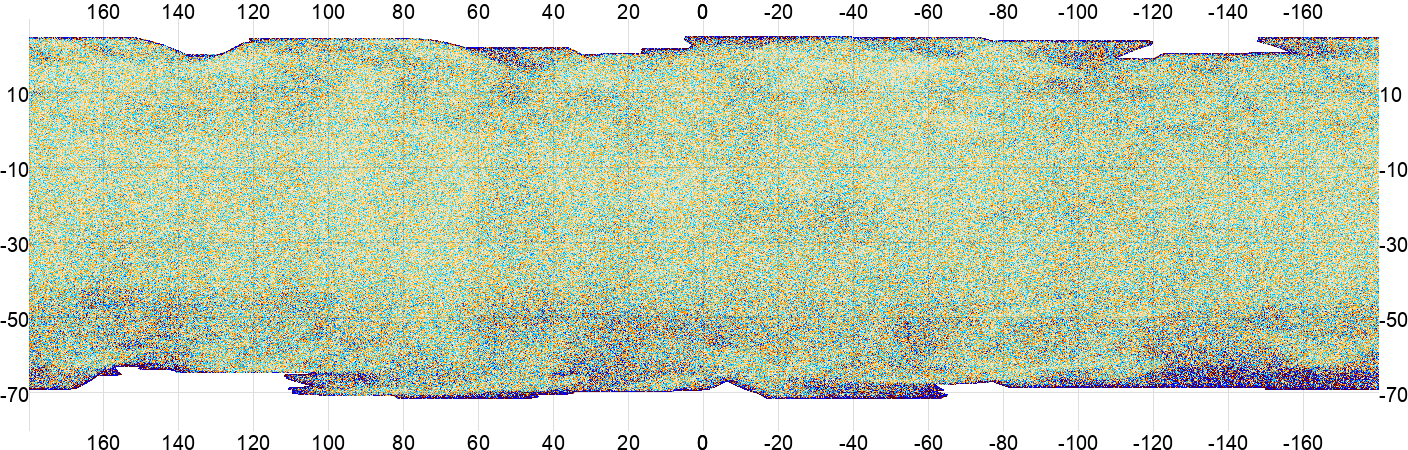

In [104]:
omap = nsim.simulate(tube,mask_value=0,atmosphere=False)
plot(omap[0][0][0])

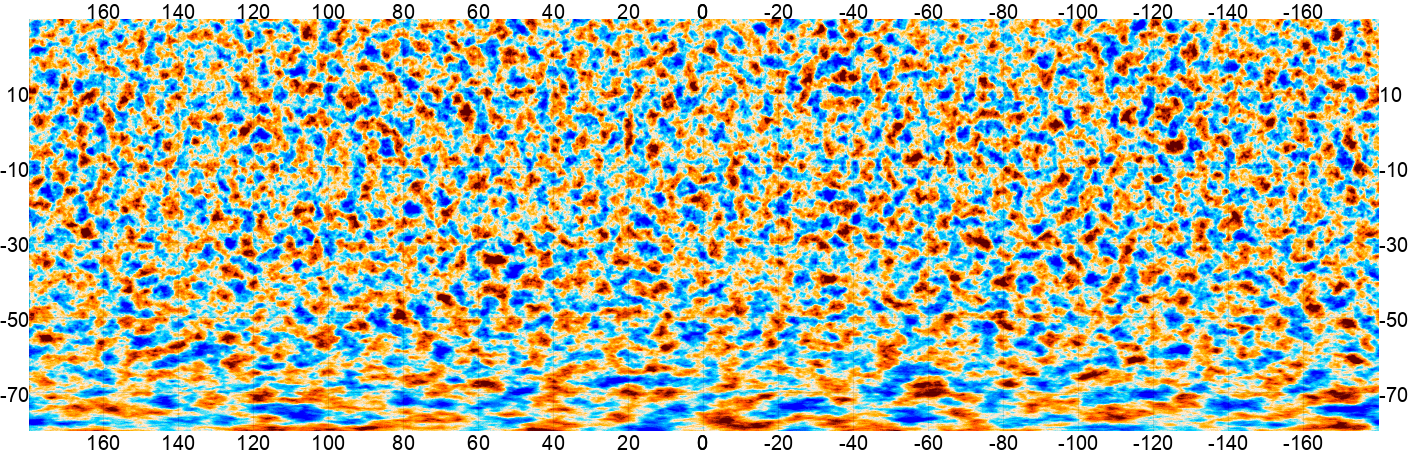

In [136]:
nsim = mapsims.noise.SONoiseSimulator(shape=shape,wcs=wcs,homogeneous=True,sky_fraction=0.4)


In [141]:
np.sqrt(nsim.get_white_noise_power('LT3',0.4)) * 180.*60./np.pi

array([16.07204425, 19.94124009])